# **Getting Started** 

# Library

In [1]:
# Suppress TensorFlow warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
import logging
tf.get_logger().setLevel(logging.ERROR)
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Standard libraries
import numpy as np
import matplotlib.pyplot as plt
import zipfile
from tensorflow.keras import layers
import shutil

#Plots
import matplotlib.pyplot as plt
from PIL import Image

E0000 00:00:1771130811.782690      24 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1771130811.833477      24 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1771130812.259137      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771130812.259178      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771130812.259181      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771130812.259184      24 computation_placer.cc:177] computation placer already registered. Please check linka

**Loading Dataset**

In [2]:
DATA_PATH = "/kaggle/input/gan-getting-started"

monet_path = os.path.join(DATA_PATH, "monet_jpg")
photo_path = os.path.join(DATA_PATH, "photo_jpg")

print("Photos:", len(os.listdir(photo_path)))
print("Monet:", len(os.listdir(monet_path)))


Photos: 7038
Monet: 300


**Build TensorFlow Dataset (Nothing Fancy)**

In [3]:
train_photo = tf.data.Dataset.list_files(photo_path + "/*.jpg", shuffle=True)
train_monet = tf.data.Dataset.list_files(monet_path + "/*.jpg", shuffle=True)

print(train_photo)
print(train_monet)

I0000 00:00:1771130825.855341      24 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15511 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


<_ShuffleDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>
<_ShuffleDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>


**Image Preprocessing**

In [4]:
def preprocess_image(file_path):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = (image * 2.0) - 1.0  # Normalize to [-1,1]
    return image


**Apply Preprocessing + Batch**

In [5]:
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 1

train_photo_ds = train_photo.map(preprocess_image, num_parallel_calls=AUTOTUNE)
train_monet_ds = train_monet.map(preprocess_image, num_parallel_calls=AUTOTUNE)

train_photo_ds = train_photo_ds.batch(BATCH_SIZE)
train_monet_ds = train_monet_ds.batch(BATCH_SIZE)


**Inspect Dataset: a few inages**

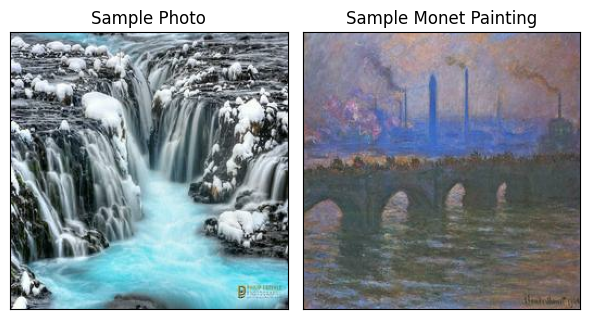

In [6]:
sample_photo = next(iter(train_photo_ds))
sample_monet = next(iter(train_monet_ds))

fig, axes = plt.subplots(1, 2, figsize=(6,6))

axes[0].imshow((sample_photo[0] + 1) / 2)
axes[0].set_title("Sample Photo")
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[0].set_frame_on(True)

axes[1].imshow((sample_monet[0] + 1) / 2)
axes[1].set_title("Sample Monet Painting")
axes[1].set_xticks([])
axes[1].set_yticks([])
axes[1].set_frame_on(True)

plt.tight_layout()
plt.show()


**Build Generator**

In [7]:
# CycleGAN Generator
def resnet_block(x):
    skip = x
    x = layers.Conv2D(256, 3, padding="same")(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(256, 3, padding="same")(x)
    return layers.add([skip, x])

def build_generator():
    inputs = layers.Input(shape=[256,256,3])
    
    x = layers.Conv2D(64, 7, padding="same")(inputs)
    x = layers.ReLU()(x)
    
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.ReLU()(x)
    
    x = layers.Conv2D(256, 3, strides=2, padding="same")(x)
    x = layers.ReLU()(x)
    
    for _ in range(6):
        x = resnet_block(x)
    
    x = layers.Conv2DTranspose(128, 3, strides=2, padding="same")(x)
    x = layers.ReLU()(x)
    
    x = layers.Conv2DTranspose(64, 3, strides=2, padding="same")(x)
    x = layers.ReLU()(x)
    
    outputs = layers.Conv2D(3, 7, padding="same", activation="tanh")(x)
    
    return tf.keras.Model(inputs, outputs)


**Create Generators**

In [8]:
generator_g = build_generator()  # Photo → Monet
generator_f = build_generator()  # Monet → Photo

print("Generator G (Photo → Monet):")
generator_g.summary()

Generator G (Photo → Monet):


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      9,472 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 256, 256,  │          0 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     73,856 │ re_lu[0][0]       │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │    295,168 │ re_lu_1[0][0]     │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 64, 64,    │          0 │ conv2d_2[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    590,080 │ re_lu_2[0][0]     │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    590,080 │ re_lu_3[0][0]     │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 64, 64,    │          0 │ re_lu_2[0][0],    │
│                     │ 256)              │            │ conv2d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ add[0][0]         │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_4 (ReLU)      │ (None, 64, 64,    │          0 │ conv2d_5[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 64, 64,    │    590,080 │ re_lu_4[0][0]     │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 64, 64,    │          0 │ add[0][0],        │
│                     │ 256)              │            │ conv2d_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 64, 64,    │    590,080 │ add_1[0][0]       │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_5 (ReLU)      │ (None, 64, 64,    │          0 │ conv2d_7[0][0]  

 Total params: 7,837,699 (29.90 MB)

 Trainable params: 7,837,699 (29.90 MB)

 Non-trainable params: 0 (0.00 B)

**Build Discriminator**

In [9]:
def build_discriminator():
    inputs = layers.Input(shape=[256,256,3])
    
    x = layers.Conv2D(64, 4, strides=2, padding="same")(inputs)
    x = layers.LeakyReLU(0.2)(x)
    
    x = layers.Conv2D(128, 4, strides=2, padding="same")(x)
    x = layers.LeakyReLU(0.2)(x)
    
    x = layers.Conv2D(256, 4, strides=2, padding="same")(x)
    x = layers.LeakyReLU(0.2)(x)
    
    outputs = layers.Conv2D(1, 4, padding="same")(x)
    
    return tf.keras.Model(inputs, outputs)


**Create Discriminator**

In [10]:
discriminator_x = build_discriminator()  # Photo discriminator
discriminator_y = build_discriminator()  # Monet discriminator

print("Discriminators created successfully.")


Discriminators created successfully.


**Define Loss Functions**

In [11]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)
    generated_loss = loss_obj(tf.zeros_like(generated), generated)
    return (real_loss + generated_loss) * 0.5

def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

def cycle_loss(real_image, cycled_image):
    return tf.reduce_mean(tf.abs(real_image - cycled_image)) * 10
    
def identity_loss(real_image, same_image):
    return tf.reduce_mean(tf.abs(real_image - same_image)) * 5


**Optimizers**

In [12]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

print("Optimizers ready.")


Optimizers ready.


**Training Step Function**

In [13]:
@tf.function
def train_step(real_x, real_y):
    with tf.GradientTape(persistent=True) as tape:
        
        # Photo → Monet
        fake_y = generator_g(real_x, training=True)
        cycled_x = generator_f(fake_y, training=True)
        
        # Monet → Photo
        fake_x = generator_f(real_y, training=True)
        cycled_y = generator_g(fake_x, training=True)

        # Identity mapping
        same_x = generator_f(real_x, training=True)
        same_y = generator_g(real_y, training=True)

        # Discriminator predictions
        disc_real_x = discriminator_x(real_x, training=True)
        disc_real_y = discriminator_y(real_y, training=True)
        
        disc_fake_x = discriminator_x(fake_x, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)
        
        # Generator losses
        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)
        

        total_cycle_loss = cycle_loss(real_x, cycled_x) + cycle_loss(real_y, cycled_y)

        # Identity loss
        id_loss = identity_loss(real_y, same_y) + identity_loss(real_x, same_x)

        total_gen_g_loss = gen_g_loss + total_cycle_loss + id_loss
        total_gen_f_loss = gen_f_loss + total_cycle_loss + id_loss

        # Discriminator losses
        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)
    
    # Apply gradients
    generator_g_optimizer.apply_gradients(
        zip(tape.gradient(total_gen_g_loss, generator_g.trainable_variables),
            generator_g.trainable_variables)
    )
    
    generator_f_optimizer.apply_gradients(
        zip(tape.gradient(total_gen_f_loss, generator_f.trainable_variables),
            generator_f.trainable_variables)
    )
    
    discriminator_x_optimizer.apply_gradients(
        zip(tape.gradient(disc_x_loss, discriminator_x.trainable_variables),
            discriminator_x.trainable_variables)
    )
    
    discriminator_y_optimizer.apply_gradients(
        zip(tape.gradient(disc_y_loss, discriminator_y.trainable_variables),
            discriminator_y.trainable_variables)
    )


**Training Loop(Trial)**

In [14]:
EPOCHS = 30 

for epoch in range(EPOCHS):
    print(f"Starting Epoch {epoch+1}/{EPOCHS}")
    
    for real_x, real_y in tf.data.Dataset.zip((train_photo_ds, train_monet_ds)):
        train_step(real_x, real_y)
    
    print(f"Finished Epoch {epoch+1}")


Starting Epoch 1/30


I0000 00:00:1771130846.340439      64 cuda_dnn.cc:529] Loaded cuDNN version 91002


Finished Epoch 1
Starting Epoch 2/30
Finished Epoch 2
Starting Epoch 3/30
Finished Epoch 3
Starting Epoch 4/30
Finished Epoch 4
Starting Epoch 5/30
Finished Epoch 5
Starting Epoch 6/30
Finished Epoch 6
Starting Epoch 7/30
Finished Epoch 7
Starting Epoch 8/30
Finished Epoch 8
Starting Epoch 9/30
Finished Epoch 9
Starting Epoch 10/30
Finished Epoch 10
Starting Epoch 11/30
Finished Epoch 11
Starting Epoch 12/30
Finished Epoch 12
Starting Epoch 13/30
Finished Epoch 13
Starting Epoch 14/30
Finished Epoch 14
Starting Epoch 15/30
Finished Epoch 15
Starting Epoch 16/30
Finished Epoch 16
Starting Epoch 17/30
Finished Epoch 17
Starting Epoch 18/30
Finished Epoch 18
Starting Epoch 19/30
Finished Epoch 19
Starting Epoch 20/30
Finished Epoch 20
Starting Epoch 21/30
Finished Epoch 21
Starting Epoch 22/30
Finished Epoch 22
Starting Epoch 23/30
Finished Epoch 23
Starting Epoch 24/30
Finished Epoch 24
Starting Epoch 25/30
Finished Epoch 25
Starting Epoch 26/30
Finished Epoch 26
Starting Epoch 27/30
Fin

**Displaying Output after training on 30 epocs**

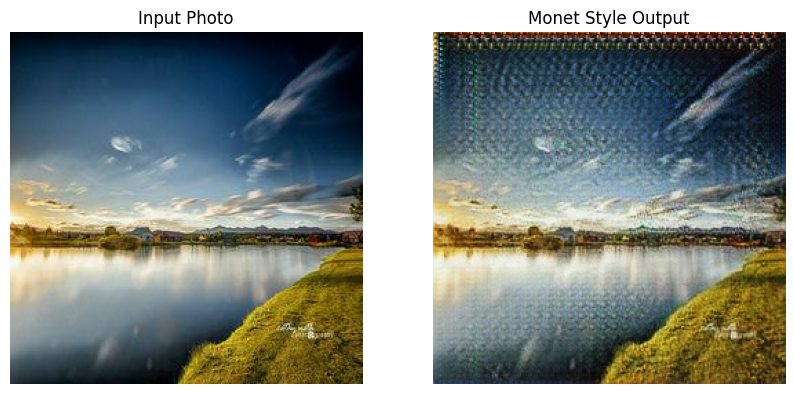

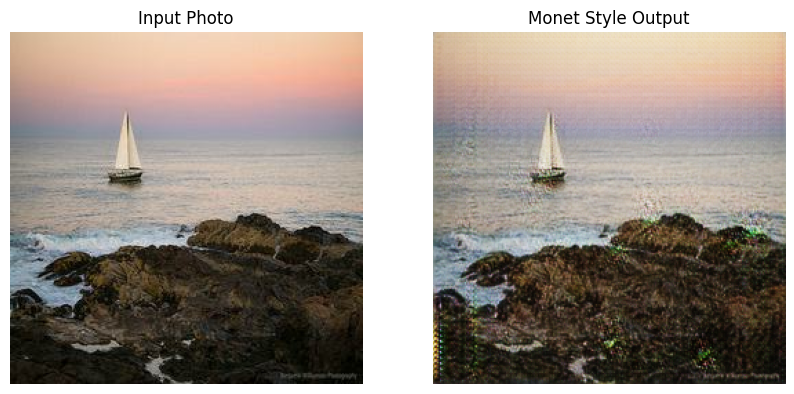

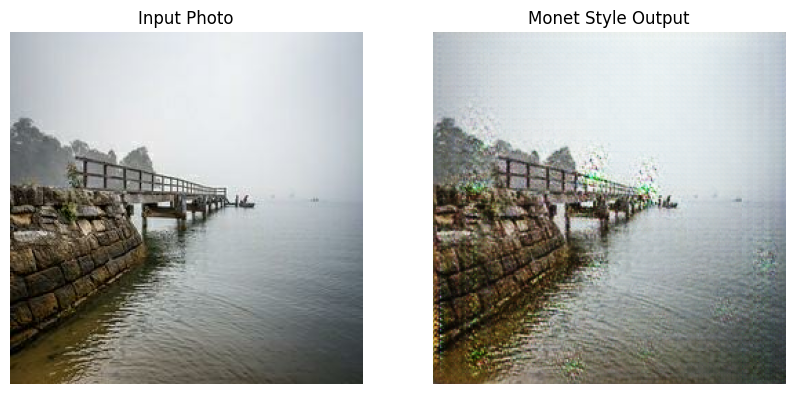

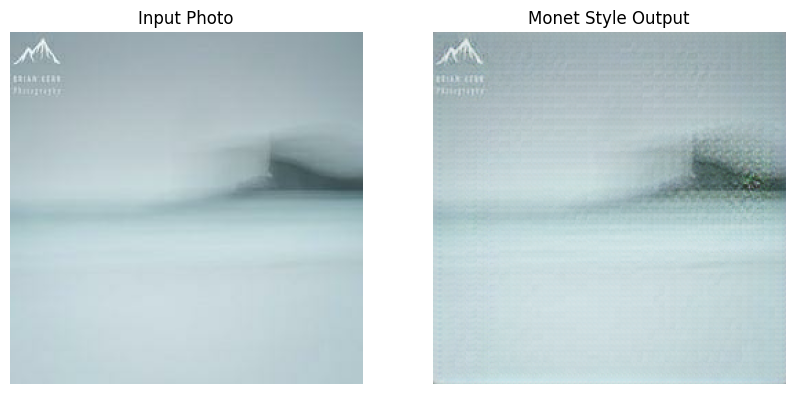

In [15]:

def show_translation(photo_batch, generator):
    prediction = generator(photo_batch, training=False)

    plt.figure(figsize=(10,7))

    display_list = [photo_batch[0], prediction[0]]
    title = ['Input Photo', 'Monet Style Output']

    for i in range(2):
        plt.subplot(1,2,i+1 )
        plt.title(title[i])
        plt.imshow((display_list[i] * 0.5) + 0.5)  # denormalize
        plt.axis('off')

    plt.show()

# Take one sample batch
for sample_photo in train_photo_ds.take(4):
    show_translation(sample_photo, generator_g)


**Kaggle Submission Session**

<h4>part 1</h4>

**Submission File**

In [16]:

#output_dir = "generated_images"
#os.makedirs(output_dir, exist_ok=True)

#count = 0

#for batch in train_photo_ds:
    #prediction = generator_g(batch, training=False)
    
    #for i in range(prediction.shape[0]):
       # img = (prediction[i] * 0.5 + 0.5) * 255
       # img = tf.cast(img, tf.uint8)
       # img = Image.fromarray(img.numpy())
       # img.save(f"{output_dir}/{count}.jpg")
       # count += 1


In [17]:

#with zipfile.ZipFile("images.zip", "w") as z:
  #  for file in os.listdir(output_dir):
       # z.write(os.path.join(output_dir, file), arcname=file)
#print("Zip file created successfully.")

In [18]:
from PIL import Image
import os
import numpy as np
import shutil

os.makedirs("/kaggle/working/images", exist_ok=True)

i = 1
for img in train_photo_ds.unbatch().take(10000):

    img = tf.expand_dims(img, axis=0)
    prediction = generator_g(img, training=False)[0].numpy()

    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)

    im = Image.fromarray(prediction)
    im.save(f"/kaggle/working/images/{i}.jpg")

    i += 1

shutil.make_archive("images", 'zip', "/kaggle/working/images")


'/kaggle/working/images.zip'